Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Working Directory:  /content/drive/My Drive/speech_project_techno_india/collegeproject

SVM Performance with noise factor 0: 0.6111111111111112
Random Forest Performance with noise factor 0: 0.7222222222222222

SVM Performance with noise factor 0.01: 0.5833333333333334
Random Forest Performance with noise factor 0.01: 0.6944444444444444

SVM Performance with noise factor 0.02: 0.5555555555555556
Random Forest Performance with noise factor 0.02: 0.3055555555555556

SVM Performance with noise factor 0.05: 0.5
Random Forest Performance with noise factor 0.05: 0.3055555555555556

SVM Performance with noise factor 0.1: 0.3611111111111111
Random Forest Performance with noise factor 0.1: 0.3611111111111111

SVM Performance with noise factor 0.2: 0.3611111111111111
Random Forest Performance with noise factor 0.2: 0.3333333333333333

SVM Performance with noise

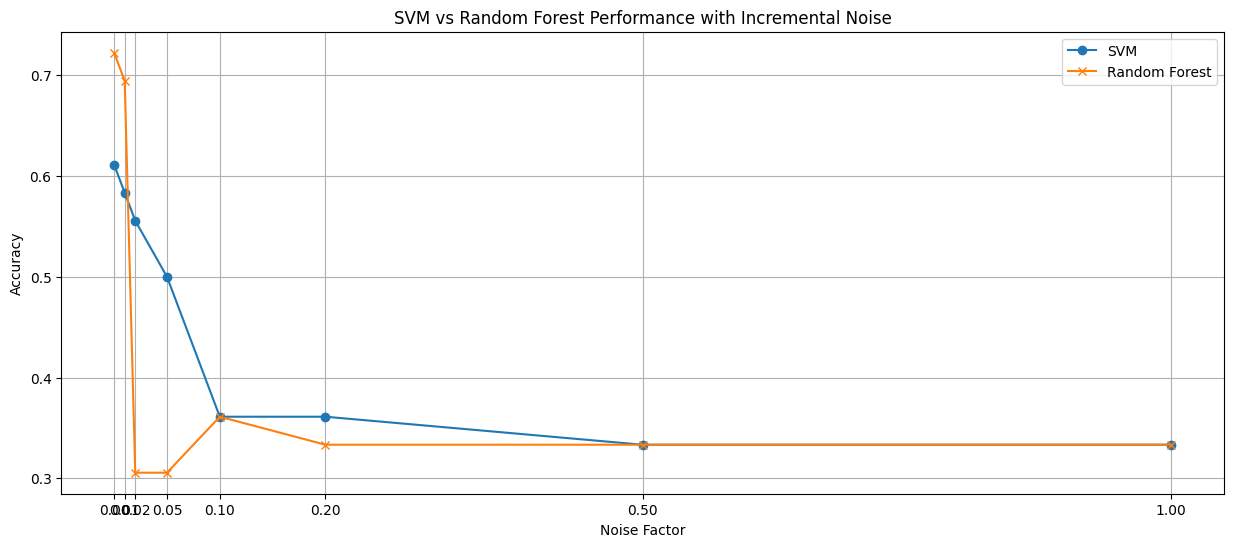

In [7]:
import os
import librosa
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
np.random.seed(42)

# Function Definitions
def extract_mfcc(y, sr, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfccs

def extract_lfcc(y, sr, n_lfcc=13):
    D = librosa.stft(y)
    magnitude, phase = librosa.magphase(D)
    S = librosa.amplitude_to_db(magnitude, ref=np.max)
    lfccs = librosa.feature.mfcc(S=S, sr=sr, n_mfcc=n_lfcc)
    return lfccs

def add_noise_by_factor(y, factor):
    noise = np.random.randn(len(y)) * factor
    y_noisy = y + noise
    return y_noisy

# Mount Drive (specific to Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set the working directory
path = '/content/drive/My Drive/speech_project_techno_india/collegeproject'
os.chdir(path)
print("Current Working Directory: ", os.getcwd())

# Data Preparation and Train/Test Split
audio_files = []
labels = []
personalities = os.listdir()

for element in personalities:
    if element not in ([".git", ".DS_Store", "README.md"]):
        substack = os.listdir(f"{os.getcwd()}/{element}")
        for file in substack:
            audio_files.append(f"{os.getcwd()}/{element}/{file}")
            labels.append(file.split("-")[0])

audio_train, audio_test, label_train, label_test = train_test_split(audio_files, labels, test_size=0.2, random_state=42)

# Feature Extraction for Training Data
#the model is trained only once and the performance is tested with increasing noise factors


features_train = []
for file in audio_train:
    try:
        y, sr = librosa.load(file)
        mfcc_features = extract_mfcc(y, sr).mean(axis=1)
        lfcc_features = extract_lfcc(y, sr).mean(axis=1)
        combined_features = np.hstack([mfcc_features, lfcc_features])
        features_train.append(combined_features)
    except Exception as e:
        print(f"Error processing file: {e}")

# Train the Model
clf = svm.SVC(kernel='linear')
clf.fit(features_train, label_train)

# Function to Test Model Performance with and without Noise
def test_model_with_and_without_noise(noise_factors, audio_test, label_test):
    accuracies = []
    for factor in noise_factors:
        features_test = []
        for file in audio_test:
            try:
                y, sr = librosa.load(file, sr=None)
                if factor != 0:  # Add noise only if the factor is non-zero
                    y = add_noise_by_factor(y, factor)
                mfcc_features = extract_mfcc(y, sr).mean(axis=1)
                lfcc_features = extract_lfcc(y, sr).mean(axis=1)
                combined_features = np.hstack([mfcc_features, lfcc_features])
                features_test.append(combined_features)
            except Exception as e:
                print(f"Error processing file with noise factor {factor}: {e}")
                continue

        X_test = np.array(features_test)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(label_test, y_pred)
        accuracies.append(accuracy)
        print(f"\nPerformance with noise factor {factor}: {accuracy}")

    return accuracies

# Include 0 in noise factors for baseline testing
noise_factors = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]

# Test the Model with and without Noise
# svm_accuracies = test_model_with_and_without_noise(noise_factors, audio_test, label_test)


from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest Model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(features_train, label_train)

# Modify the testing function to include Random Forest evaluation
def test_model_with_and_without_noise(noise_factors, audio_test, label_test):
    svm_accuracies = []
    rf_accuracies = []
    for factor in noise_factors:
        features_test = []
        for file in audio_test:
            try:
                y, sr = librosa.load(file, sr=None)
                if factor != 0:  # Add noise only if the factor is non-zero
                    y = add_noise_by_factor(y, factor)
                mfcc_features = extract_mfcc(y, sr).mean(axis=1)
                lfcc_features = extract_lfcc(y, sr).mean(axis=1)
                combined_features = np.hstack([mfcc_features, lfcc_features])
                features_test.append(combined_features)
            except Exception as e:
                print(f"Error processing file with noise factor {factor}: {e}")
                continue

        X_test = np.array(features_test)

        # SVM Predictions and Accuracy
        y_pred_svm = clf.predict(X_test)
        accuracy_svm = accuracy_score(label_test, y_pred_svm)
        svm_accuracies.append(accuracy_svm)

        # Random Forest Predictions and Accuracy
        y_pred_rf = rf_clf.predict(X_test)
        accuracy_rf = accuracy_score(label_test, y_pred_rf)
        rf_accuracies.append(accuracy_rf)

        print(f"\nSVM Performance with noise factor {factor}: {accuracy_svm}")
        print(f"Random Forest Performance with noise factor {factor}: {accuracy_rf}")

    return svm_accuracies, rf_accuracies

# Test the Models with and without Noise
svm_accuracies, rf_accuracies = test_model_with_and_without_noise(noise_factors, audio_test, label_test)

# Plotting the Results for Both Models
plt.figure(figsize=(15, 6))
plt.plot(noise_factors, svm_accuracies, marker='o', label='SVM')
plt.plot(noise_factors, rf_accuracies, marker='x', label='Random Forest')
plt.xlabel('Noise Factor')
plt.ylabel('Accuracy')
plt.title('SVM vs Random Forest Performance with Incremental Noise')
plt.xticks(noise_factors)
plt.legend()
plt.grid()
plt.show()


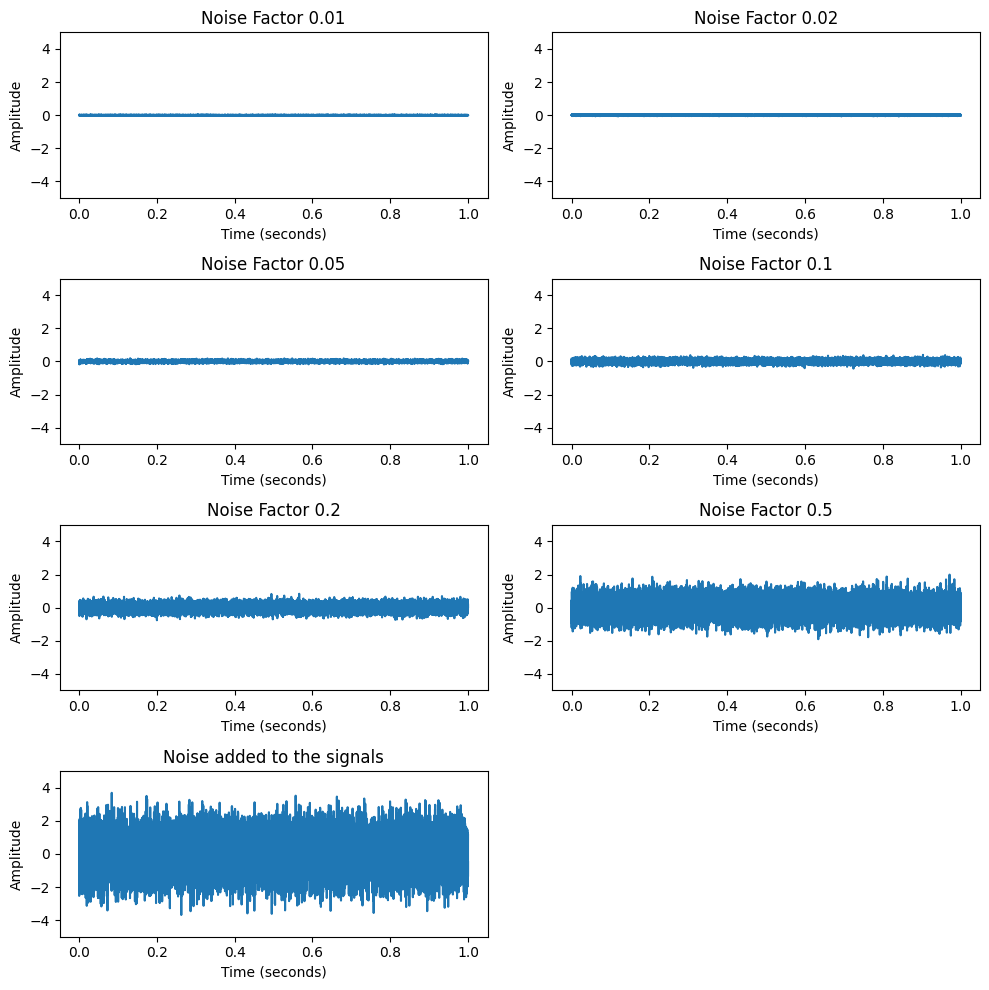

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define the duration and sample rate
duration = 1.0  # seconds
sample_rate = 22050  # Hz
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Define the noise factors
noise_factors = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]

# Function to generate noise
def generate_noise(factor):
    noise = np.random.randn(len(t)) * factor
    return noise

# Determine the layout of the grid
n_factors = len(noise_factors)
n_cols = 2  # Adjust as needed
n_rows = np.ceil(n_factors / n_cols).astype(int)

# Create the grid of subplots with y-axis limits set to -5 to 5
plt.figure(figsize=(10, n_rows * 2.5))
for i, factor in enumerate(noise_factors):
    plt.subplot(n_rows, n_cols, i+1)
    noise = generate_noise(factor)
    plt.plot(t, noise)
    plt.ylim(-5, 5)  # Set y-axis limits to -5 to +5
    plt.title(f'Noise Factor {factor}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
plt.title("Noise added to the signals")
plt.tight_layout()

plt.show()
